In [111]:
import warnings
import math
import datetime
import time
import itertools

import numpy as np
import pandas as pd
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.subplots as sp

import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

#### **Import Data DRIAS-CLIMAT** 
- Production : eurocordex2020
- Modele : CNRM-ALADIN63 - CNRM-CERFACS-CNRM-CM5 (RCM - GCM)
- Scenario : rcp4.5 / rcp2.5
- Donnees CORRIGEES
- Periode : 01/01/2006 - 31/12/2100
    1. <span style="color: #7369FFFF;">Format de la ligne</span>  : "Date Latitude Longitude  tasminAdjust tasmaxAdjust tasAdjust prtotAdjust prsnAdjust
    2. <span style="color: #7369FFFF;">Date</span> : Date du jour sous la forme 'JJ/MM/AAAA'
    3. <span style="color: #7369FFFF;">Latitude Longitude</span> : position du point de grille SAFRAN en degres decimaux (WGS84)
    4. <span style="color: #7369FFFF;">tasminAdjust</span> : Temperature minimale journaliere a 2 m [K]
    5. <span style="color: #7369FFFF;">tasmaxAdjust</span> : Temperature maximale journaliere a 2 m [K]
    6. <span style="color: #7369FFFF;">tasAdjust</span> : Temperature moyenne a 2 m [K]
    7. <span style="color: #7369FFFF;">prtotAdjust</span> : Precipitations totales [kg/m2/s]
    8. <span style="color: #7369FFFF;">prsnAdjust</span> : Precipitations solides [kg/m2/s]
    9. <span style="color: #7369FFFF;">hussAdjust</span> : Humidite specifique a 2 m [kg/kg]
    10. <span style="color: #7369FFFF;">rsdsAdjust</span> : Rayonnement visible incident a la surface [W/m2]
    11. <span style="color: #7369FFFF;">rldsAdjust</span> : Rayonnement infra-rouge incident a la surface [W/m2]
    12. <span style="color: #7369FFFF;">sfcWindAdjust</span> : Vitesse du vent a 10 m [m/s]
    13. <span style="color: #7369FFFF;">evspsblpotAdjust</span> : Evapo-transpiration potentielle Hargreaves [kg/m2/s]

In [ ]:
data_rcp_4_5 = pd.read_excel('CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp4.5_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_4_5['Date'] = pd.to_datetime(data_rcp_4_5['Date'], format='%d/%m/%Y')
data_rcp_4_5.set_index('Date', inplace=True)
data_rcp_4_5.head()     

Latitude  Longitude  tasminAdjust  tasmaxAdjust  tasAdjust  \
Date                                                                     
2006-01-01   49.2427    4.03882        270.00        277.80     273.13   
2006-01-02   49.2427    4.03882        273.19        277.21     275.18   
2006-01-03   49.2427    4.03882        281.74        282.12     281.97   
2006-01-04   49.2427    4.03882        282.91        286.21     285.07   
2006-01-05   49.2427    4.03882        278.30        284.15     280.35   

            prtotAdjust  prsnAdjust  hussAdjust  rsdsAdjust  rldsAdjust  \
Date                                                                      
2006-01-01     0.000003    0.000003    0.003503      53.157     264.926   
2006-01-02     0.000097    0.000012    0.005015       9.143     347.306   
2006-01-03     0.000008    0.000000    0.008196       8.756     381.686   
2006-01-04     0.000001    0.000000    0.007773      16.775     355.457   
2006-01-05     0.000000    0.000000    0.006088      29.116     337.960   

            sfcWindAdjust  evspsblpotAdjust  
Date                                         
2006-01-01          2.138      1.800000e-06  
2006-01-02          7.012      5.000000e-07  
2006-01-03          8.374      2.000000e-06  
2006-01-04          5.803      5.500000e-06  
2006-01-05          1.557      2.200000e-06

In [36]:
data_rcp_2_6 = pd.read_excel('CNRM-CERFACS-CNRM-CM5_CNRM-ALADIN63_rcp2.6_METEO-FRANCE_ADAMONT-France_SAFRAN_day_2006_2100.xlsx')
data_rcp_2_6['Date'] = pd.to_datetime(data_rcp_2_6['Date'], format='%d/%m/%Y')
data_rcp_2_6.set_index('Date', inplace=True)
data_rcp_2_6.head()

Latitude  Longitude  tasminAdjust  tasmaxAdjust  tasAdjust  \
Date                                                                     
2006-01-01   49.2427    4.03882        270.00        277.74     273.11   
2006-01-02   49.2427    4.03882        273.39        277.19     275.27   
2006-01-03   49.2427    4.03882        281.72        282.36     282.11   
2006-01-04   49.2427    4.03882        283.02        287.32     285.83   
2006-01-05   49.2427    4.03882        280.74        284.66     282.11   

            prtotAdjust  prsnAdjust  hussAdjust  rsdsAdjust  rldsAdjust  \
Date                                                                      
2006-01-01     0.000000    0.000000    0.003508      53.716     265.013   
2006-01-02     0.000102    0.000011    0.004973       9.241     344.004   
2006-01-03     0.000009    0.000000    0.008280       7.535     382.930   
2006-01-04     0.000005    0.000000    0.008134      19.244     356.590   
2006-01-05     0.000000    0.000000    0.006754      14.233     367.906   

            sfcWindAdjust  evspsblpotAdjust  
Date                                         
2006-01-01          2.181      1.800000e-06  
2006-01-02          7.124      6.000000e-07  
2006-01-03          8.292      1.800000e-06  
2006-01-04          5.446      5.000000e-06  
2006-01-05          2.020      3.400000e-06

In [37]:
# Conversion température de Kelvin (K) en Celsius (°C) 
data_rcp_4_5['tasminAdjust'] = data_rcp_4_5['tasminAdjust'] - 273.15
data_rcp_4_5['tasmaxAdjust'] = data_rcp_4_5['tasmaxAdjust'] - 273.15
data_rcp_4_5['tasAdjust'] = data_rcp_4_5['tasAdjust'] - 273.15
data_rcp_4_5.head()

Latitude  Longitude  tasminAdjust  tasmaxAdjust  tasAdjust  \
Date                                                                     
2006-01-01   49.2427    4.03882         -3.15          4.65      -0.02   
2006-01-02   49.2427    4.03882          0.04          4.06       2.03   
2006-01-03   49.2427    4.03882          8.59          8.97       8.82   
2006-01-04   49.2427    4.03882          9.76         13.06      11.92   
2006-01-05   49.2427    4.03882          5.15         11.00       7.20   

            prtotAdjust  prsnAdjust  hussAdjust  rsdsAdjust  rldsAdjust  \
Date                                                                      
2006-01-01     0.000003    0.000003    0.003503      53.157     264.926   
2006-01-02     0.000097    0.000012    0.005015       9.143     347.306   
2006-01-03     0.000008    0.000000    0.008196       8.756     381.686   
2006-01-04     0.000001    0.000000    0.007773      16.775     355.457   
2006-01-05     0.000000    0.000000    0.006088      29.116     337.960   

            sfcWindAdjust  evspsblpotAdjust  
Date                                         
2006-01-01          2.138      1.800000e-06  
2006-01-02          7.012      5.000000e-07  
2006-01-03          8.374      2.000000e-06  
2006-01-04          5.803      5.500000e-06  
2006-01-05          1.557      2.200000e-06

In [38]:
# Conversion température de Kelvin (K) en Celsius (°C) 
data_rcp_2_6['tasminAdjust'] = data_rcp_2_6['tasminAdjust'] - 273.15
data_rcp_2_6['tasmaxAdjust'] = data_rcp_2_6['tasmaxAdjust'] - 273.15
data_rcp_2_6['tasAdjust'] = data_rcp_2_6['tasAdjust'] - 273.15
data_rcp_2_6.head()

Latitude  Longitude  tasminAdjust  tasmaxAdjust  tasAdjust  \
Date                                                                     
2006-01-01   49.2427    4.03882         -3.15          4.59      -0.04   
2006-01-02   49.2427    4.03882          0.24          4.04       2.12   
2006-01-03   49.2427    4.03882          8.57          9.21       8.96   
2006-01-04   49.2427    4.03882          9.87         14.17      12.68   
2006-01-05   49.2427    4.03882          7.59         11.51       8.96   

            prtotAdjust  prsnAdjust  hussAdjust  rsdsAdjust  rldsAdjust  \
Date                                                                      
2006-01-01     0.000000    0.000000    0.003508      53.716     265.013   
2006-01-02     0.000102    0.000011    0.004973       9.241     344.004   
2006-01-03     0.000009    0.000000    0.008280       7.535     382.930   
2006-01-04     0.000005    0.000000    0.008134      19.244     356.590   
2006-01-05     0.000000    0.000000    0.006754      14.233     367.906   

            sfcWindAdjust  evspsblpotAdjust  
Date                                         
2006-01-01          2.181      1.800000e-06  
2006-01-02          7.124      6.000000e-07  
2006-01-03          8.292      1.800000e-06  
2006-01-04          5.446      5.000000e-06  
2006-01-05          2.020      3.400000e-06

#### **Import Data Historique-Météo Reims 2009-2025**

#### 🌡️ Températures (en °C)

- MAX_TEMPERATURE_C : Température maximale observée pendant la journée.
- MIN_TEMPERATURE_C : Température minimale observée pendant la journée.
- TEMPERATURE_MORNING_C_6H : Température enregistrée à 6h du matin.
- TEMPERATURE_NOON_C_12H : Température enregistrée à midi (12h).
- TEMPERATURE_EVENING_C_18H : Température enregistrée à 18h.
- TEMPERATURE_NIGHT_C_3H : Température enregistrée à 3h du matin.
- TEMPERATURE_9H : Température enregistrée à 9h du matin.
- TEMPERATURE_15H : Température enregistrée à 15h.
- TEMPERATURE_21H : Température enregistrée à 21h.
- TEMPERATURE_MIDNIGHT_0H : Température enregistrée à minuit.

##### 🌬️ Vent

- WINDSPEED_MAX_KMH : Vitesse maximale du vent enregistrée pendant la journée (en km/h).
- WINDTEMP_MAX_C : Température ressentie à cause du vent (wind chill) maximale (en °C).

##### 💧 Humidité et précipitations

- HUMIDITY_MAX_PERCENT : Humidité relative maximale (%).
- PRECIP_TOTAL_DAY_MM : Total des précipitations journalières (en millimètres).
- TOTAL_SNOW_MM : Quantité totale de neige tombée dans la journée (en mm).
- DEWPOINT_MAX_C : Point de rosée maximum atteint dans la journée (en °C), indique la température à laquelle l’air devient saturé en humidité.

##### 🌫️ Autres conditions atmosphériques

- VISIBILITY_AVG_KM : Visibilité moyenne de la journée (en kilomètres).
- PRESSURE_MAX_MB : Pression atmosphérique maximale de la journée (en millibars).
- CLOUDCOVER_AVG_PERCENT : Couverture nuageuse moyenne de la journée (%).
- HEATINDEX_MAX_C : Indice de chaleur maximal (en °C), température ressentie en tenant compte de l'humidité.

##### 🌤️ Conditions météo codées (selon tranches horaires)

- WEATHER_CODE_MORNING_6H : Code météo à 6h du matin.
- WEATHER_CODE_NOON_12H : Code météo à 12h (midi).
- WEATHER_CODE_EVENING_18H : Code météo à 18h.
- WEATHER_CODE_NIGHT_3H : Code météo à 3h du matin.
- WEATHER_CODE_9H : Code météo à 9h.
- WEATHER_CODE_15H : Code météo à 15h.
- WEATHER_CODE_21H : Code météo à 21h.
- WEATHER_CODE_MIDNIGHT_0H : Code météo à minuit.

> 🔢 **Remarque :** Ces codes sont généralement des entiers représentant un type de météo (ex : 113 = ciel dégagé, 116 = partiellement nuageux, etc.).

##### ☀️ Rayonnement solaire

- UV_INDEX : Indice UV maximal de la journée.
- SUNHOUR : Nombre total d’heures d’ensoleillement dans la journée.
- SUNSET : Heure du coucher du soleil (format `HH:MM`).
- SUNRISE : Heure du lever du soleil (format `HH:MM`).

#####
 🧍 Opinion (subjective ou dérivée)

- OPINION : Évaluation subjective du temps de la journée (ex : "mauvais", "bon", "agréable", "caniculaire", etc.). Peut être dérivée à partir des autres données.

In [55]:
# Liste des années à importer
annees = range(2009, 2026)

# Liste pour stocker les DataFrames
dfs = []

# Boucle sur les années
for annee in annees:
    nom_fichier = f"export-reims{annee}.csv"
    df = pd.read_csv(nom_fichier, skiprows=3)
    dfs.append(df)

# Concatène tous les DataFrames en un seul
data_climate_reims_2009_2026 = pd.concat(dfs, ignore_index=True)

In [56]:
data_climate_reims_2009_2026['DATE'] = pd.to_datetime(data_climate_reims_2009_2026['DATE'], format='%Y-%m-%d')
data_climate_reims_2009_2026.set_index('DATE', inplace=True)
data_climate_reims_2009_2026.head()

MAX_TEMPERATURE_C  MIN_TEMPERATURE_C  WINDSPEED_MAX_KMH  \
DATE                                                                  
2009-01-01                  3                 -4                  8   
2009-01-02                  1                 -5                 15   
2009-01-03                  1                 -5                 14   
2009-01-04                 -1                 -6                  8   
2009-01-05                 -1                 -4                 10   

            TEMPERATURE_MORNING_C_6H  TEMPERATURE_NOON_C_12H  \
DATE                                                           
2009-01-01                        -3                       3   
2009-01-02                        -5                       1   
2009-01-03                        -4                       1   
2009-01-04                        -6                      -1   
2009-01-05                        -4                      -1   

            TEMPERATURE_EVENING_C_18H  PRECIP_TOTAL_DAY_MM  \
DATE                                                         
2009-01-01                         -3                  0.0   
2009-01-02                         -2                  0.0   
2009-01-03                         -4                  0.0   
2009-01-04                         -4                  0.0   
2009-01-05                         -2                  2.5   

            HUMIDITY_MAX_PERCENT  VISIBILITY_AVG_KM  PRESSURE_MAX_MB  ...  \
DATE                                                                  ...   
2009-01-01                    95               7.00             1029  ...   
2009-01-02                    88              10.00             1028  ...   
2009-01-03                    93              10.00             1028  ...   
2009-01-04                    68              10.00             1026  ...   
2009-01-05                    83               3.75             1021  ...   

            TEMPERATURE_NIGHT_C_3H  WEATHER_CODE_NIGHT_3H  TEMPERATURE_9H  \
DATE                                                                        
2009-01-01                      -3                    143              -2   
2009-01-02                      -5                    113              -4   
2009-01-03                      -3                    116              -3   
2009-01-04                      -6                    116              -5   
2009-01-05                      -4                    338              -3   

            WEATHER_CODE_9H  TEMPERATURE_15H  WEATHER_CODE_15H  \
DATE                                                             
2009-01-01              113                0               116   
2009-01-02              113                0               113   
2009-01-03              113               -1               113   
2009-01-04              113               -3               119   
2009-01-05              332               -1               338   

            TEMPERATURE_21H  WEATHER_CODE_21H  TEMPERATURE_MIDNIGHT_0H  \
DATE                                                                     
2009-01-01               -4               113                       -3   
2009-01-02               -2               116                       -5   
2009-01-03               -5               113                       -3   
2009-01-04               -4               116                       -6   
2009-01-05               -2               332                       -4   

            WEATHER_CODE_MIDNIGHT_0H  
DATE                                  
2009-01-01                       143  
2009-01-02                       113  
2009-01-03                       116  
2009-01-04                       113  
2009-01-05                       119  

[5 rows x 33 columns]

In [58]:
# MEAN_TEMPERATURE_C
colonnes_temp_horaires = [
    'TEMPERATURE_MORNING_C_6H',
    'TEMPERATURE_NOON_C_12H',
    'TEMPERATURE_EVENING_C_18H',
    'TEMPERATURE_NIGHT_C_3H',
    'TEMPERATURE_9H',
    'TEMPERATURE_15H',
    'TEMPERATURE_21H',
    'TEMPERATURE_MIDNIGHT_0H'
]

# Calcul de la moyenne journalière basée uniquement sur les températures horaires
data_climate_reims_2009_2026['MEAN_TEMPERATURE_C'] = data_climate_reims_2009_2026[colonnes_temp_horaires].mean(axis=1)
data_climate_reims_2009_2026['MEAN_TEMPERATURE_C']

DATE
2009-01-01    -1.875
2009-01-02    -2.750
2009-01-03    -2.750
2009-01-04    -4.375
2009-01-05    -2.625
               ...  
2025-04-26    11.875
2025-04-27    14.250
2025-04-28    14.500
2025-04-29    14.750
2025-04-30    15.750
Name: MEAN_TEMPERATURE_C, Length: 5964, dtype: float64

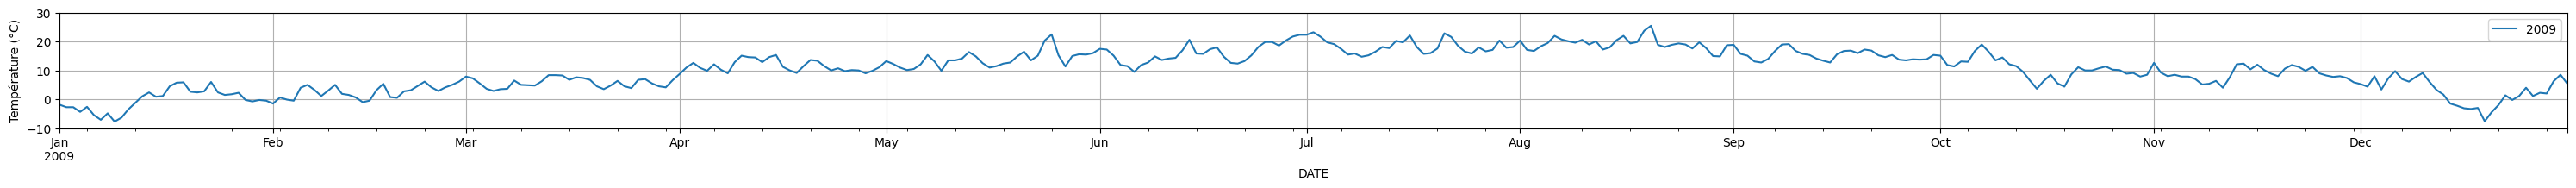

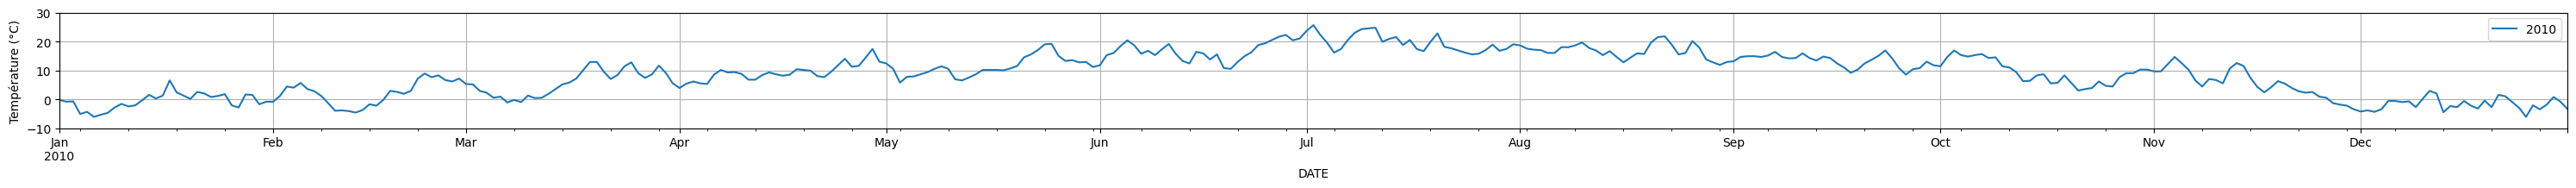

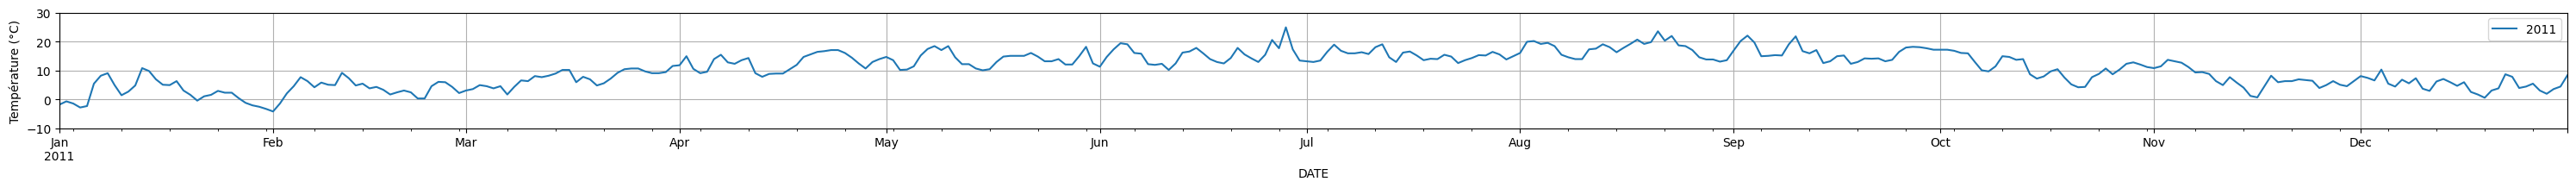

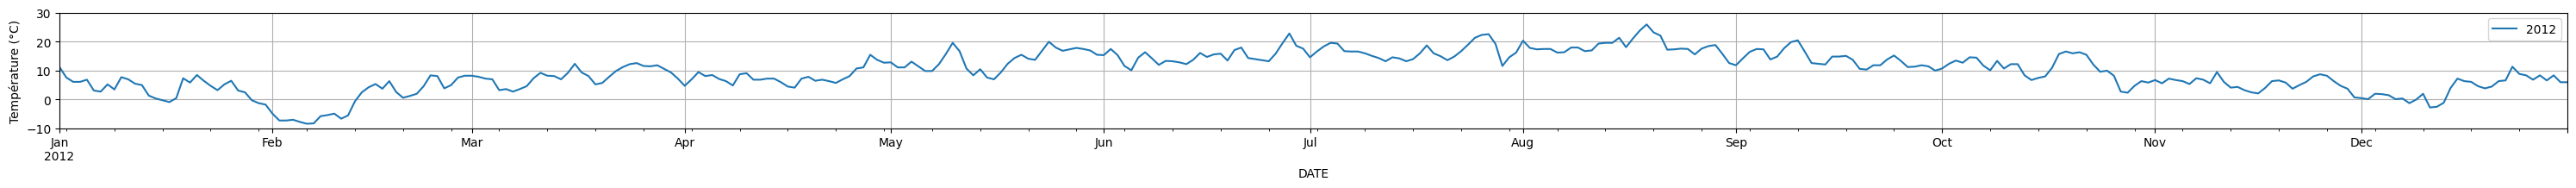

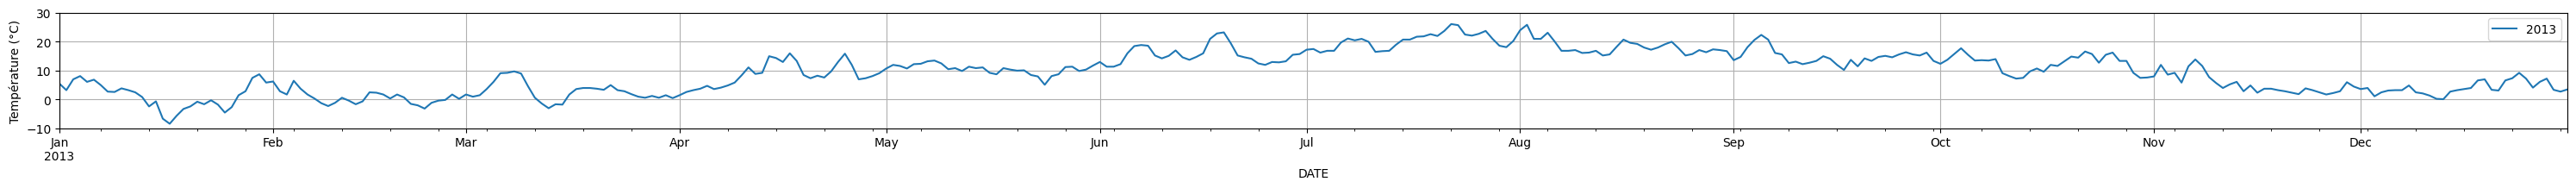

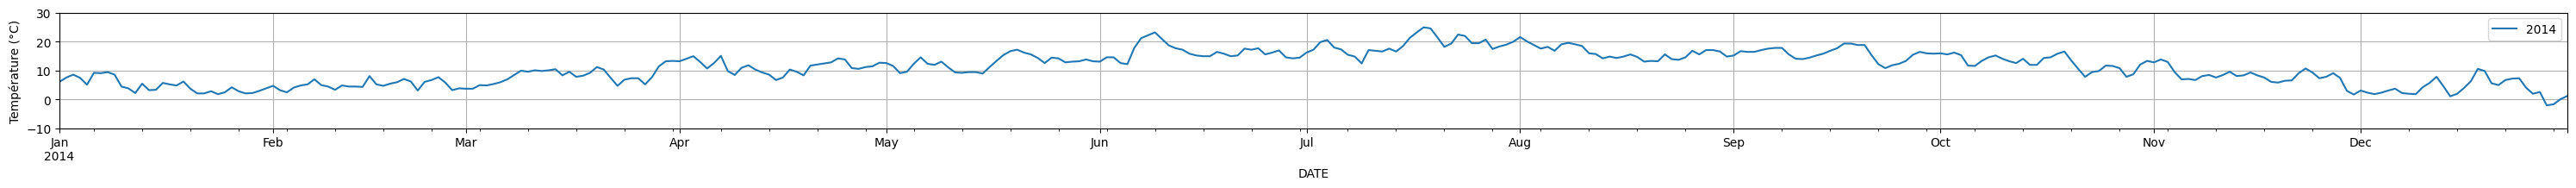

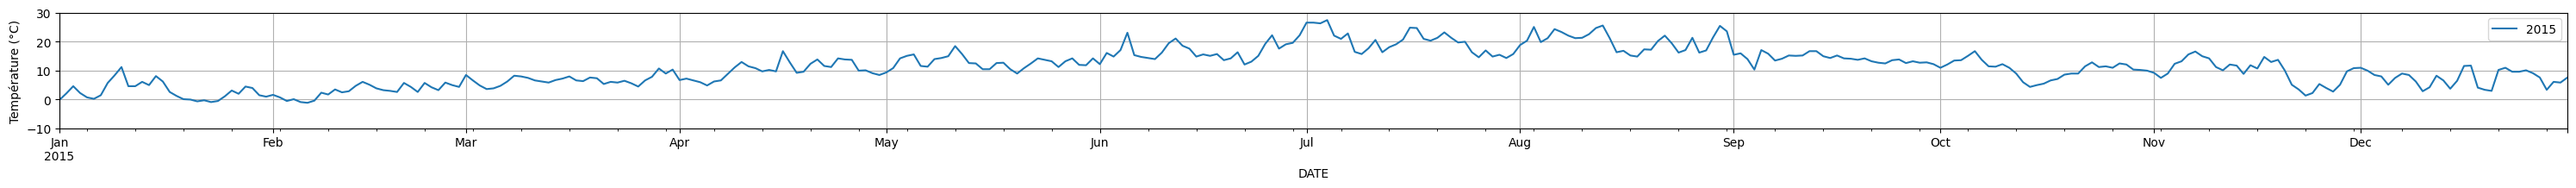

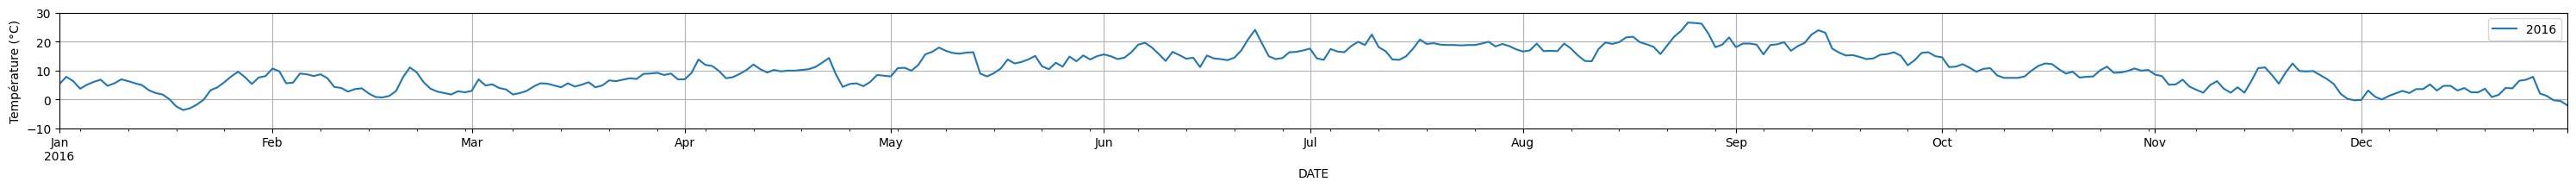

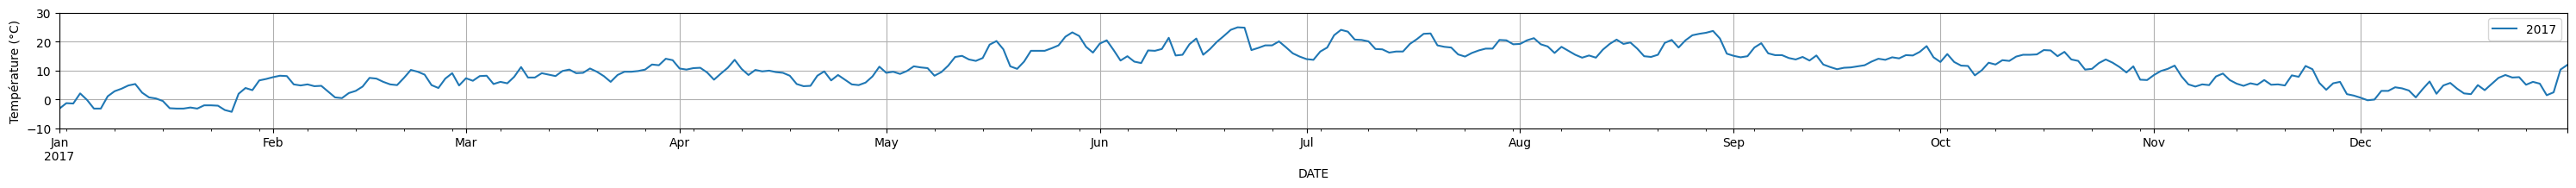

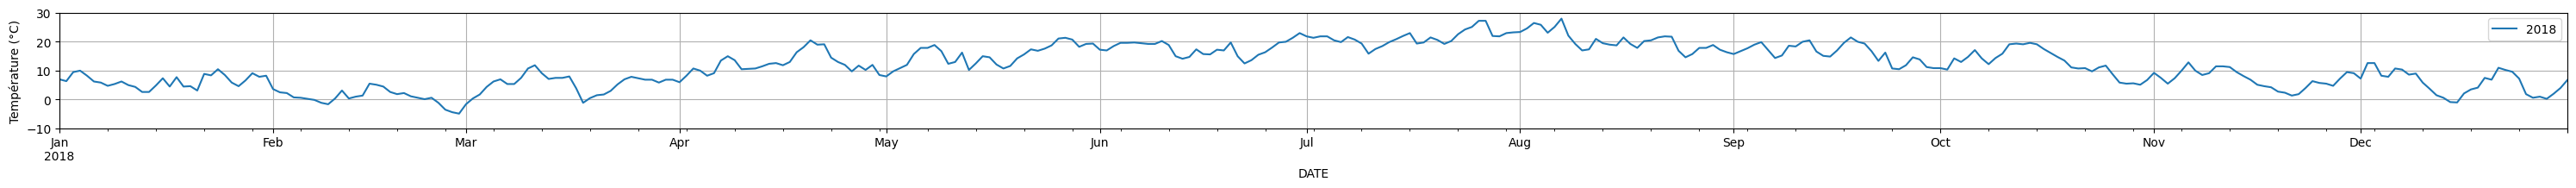

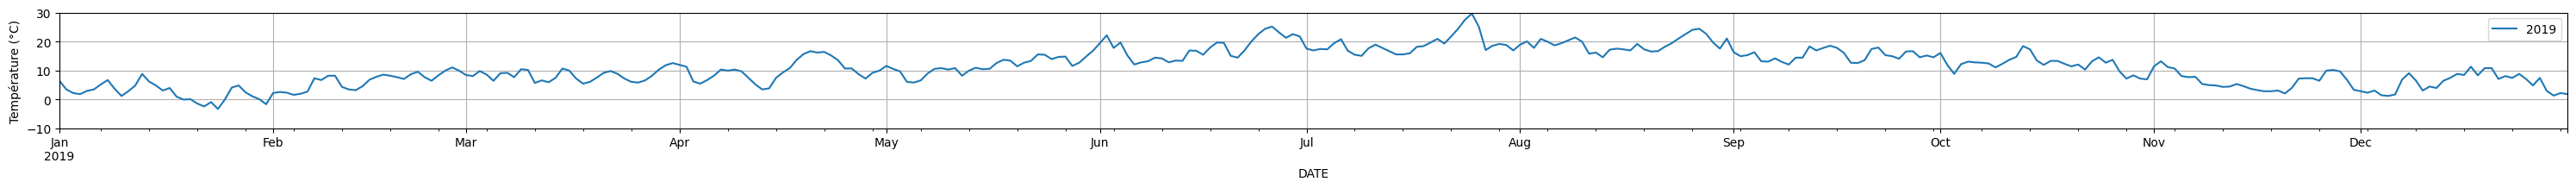

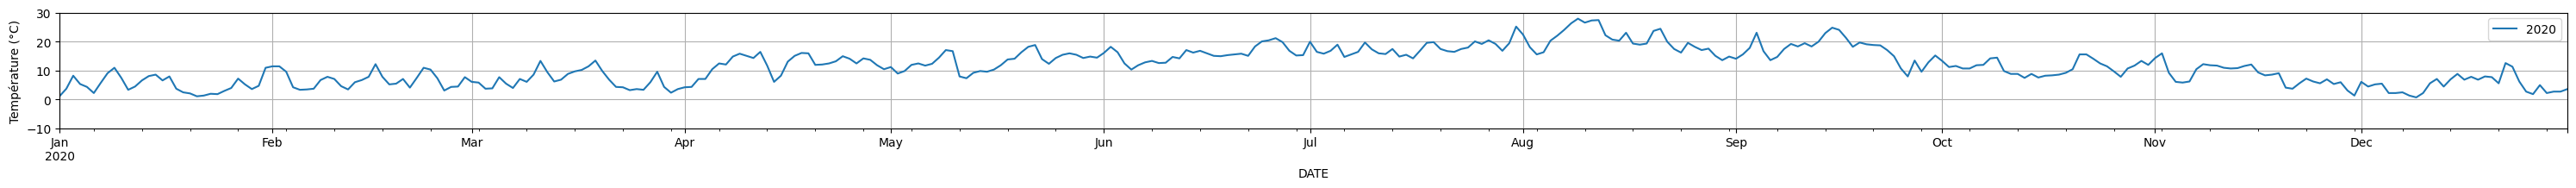

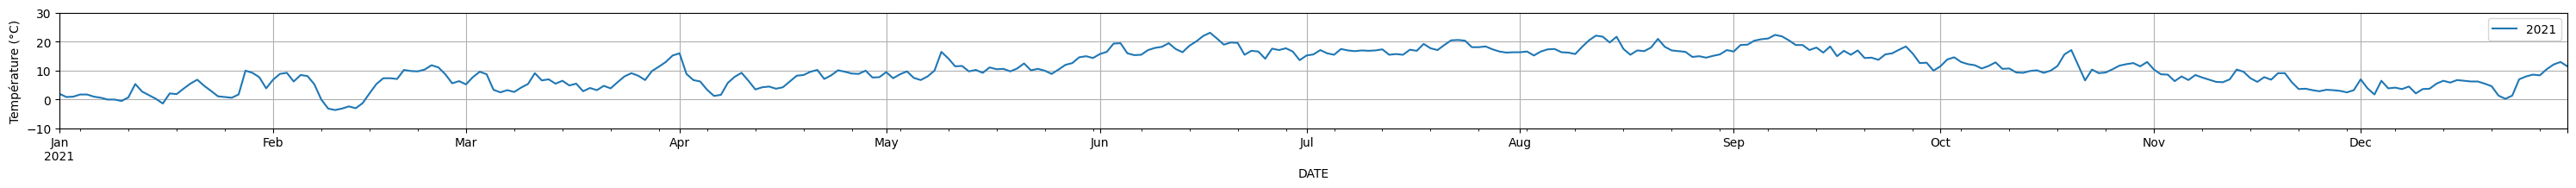

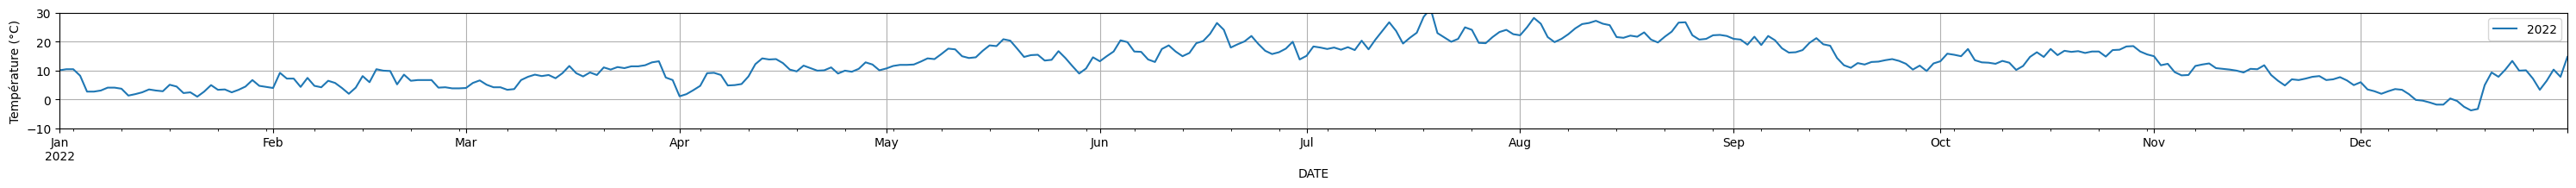

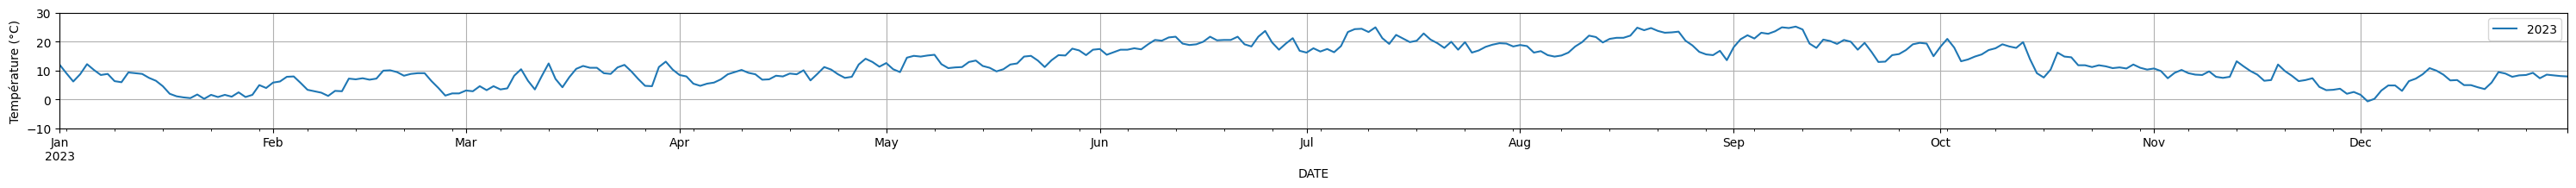

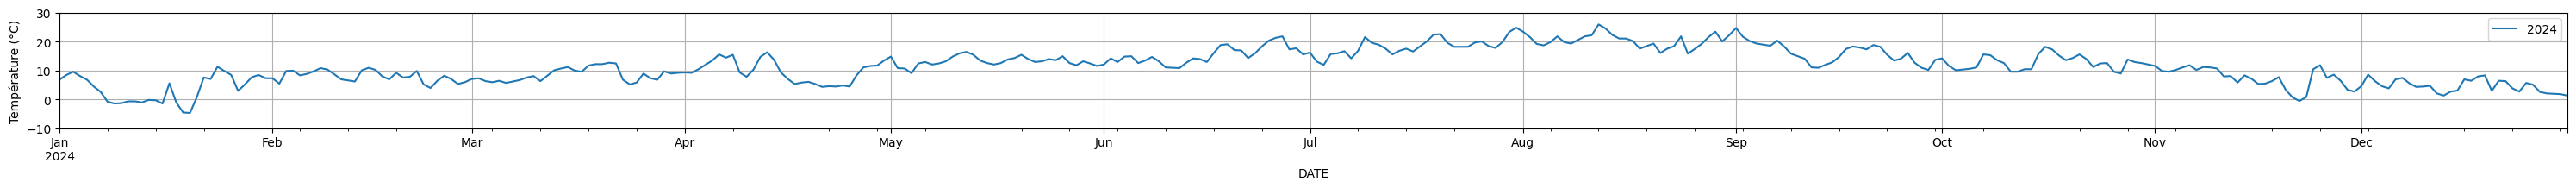

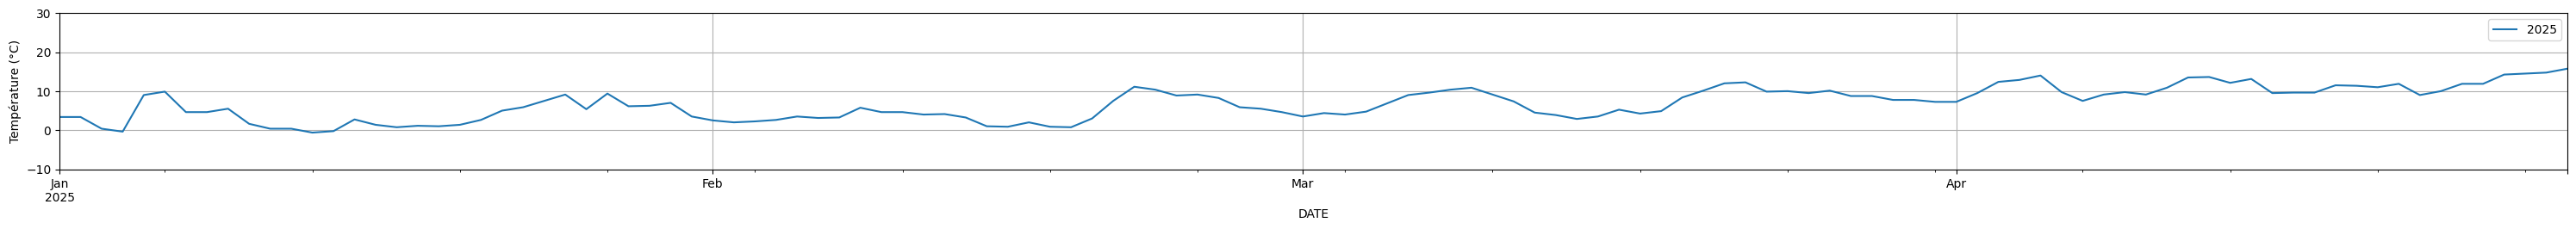

In [ ]:
# Liste des années à importer
annees = range(2009, 2026)

for i, annee in enumerate(annees, start=1):
    fig = plt.figure(figsize=(30, 35))
    ax1 = fig.add_subplot(len(annees), 1, i)

    # Filtrer les données pour l'année courante en utilisant l'index datetime
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee]

    # Tracer la courbe de température moyenne
    df_annee["MEAN_TEMPERATURE_C"].plot(ax=ax1, label=f"{annee}", color='tab:blue')
    # Détermine les bornes globales de température pour les graphiques (échelle uniforme)

    # Échelle orthonormée sur l'axe Y (identique pour tous les graphes)
    ax1.set_ylim(-10, 30)
    ax1.set_ylabel("Température (°C)", fontsize=10)
    ax1.grid(True)
    ax1.legend()

    plt.tight_layout()
    plt.show()

C:\Users\dvesa\AppData\Local\Temp\ipykernel_37104\2829748386.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(annees))


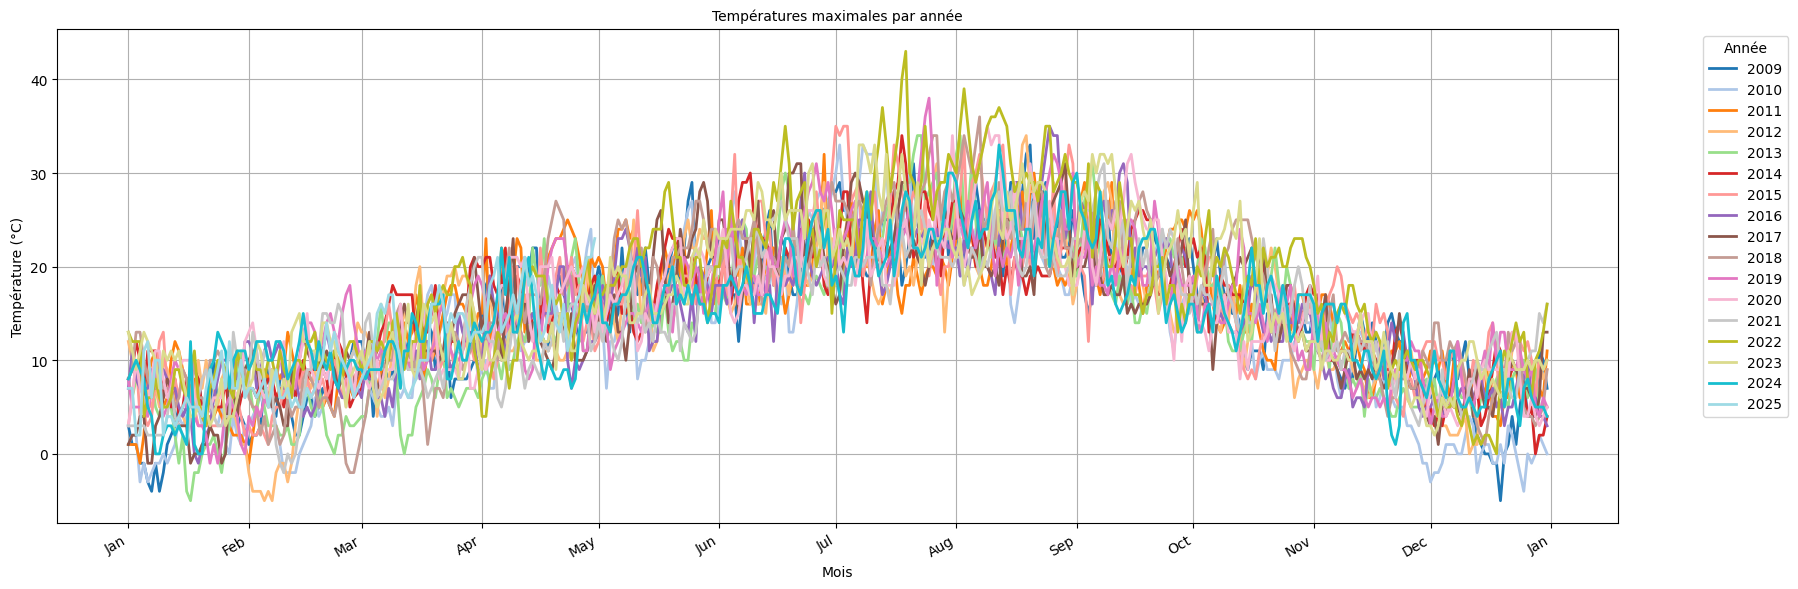

In [ ]:
# Liste des années à importer
annees = range(2009, 2026)

# Initialiser la figure
plt.figure(figsize=(18, 6))

# Colormap pour couleurs différentes par année
colors = plt.cm.get_cmap('tab20', len(annees))

for idx, annee in enumerate(annees):
    # Filtrer les données de l'année
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee].copy()

    # Remplacer l'année dans les dates par 2000 pour superposition
    df_annee.index = df_annee.index.map(lambda d: d.replace(year=2000))

    # Tracer la température maximale avec une couleur unique par année
    df_annee["MAX_TEMPERATURE_C"].plot(
        label=str(annee),
        color=colors(idx),
        lw=2
    )

# Configuration de l'axe des X pour n’afficher que les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

# Titre et labels
plt.title("Températures maximales par année", fontsize=10)
plt.xlabel("Mois")
plt.ylabel("Température (°C)")
plt.legend(title="Année", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\dvesa\AppData\Local\Temp\ipykernel_37104\3995001380.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(annees))


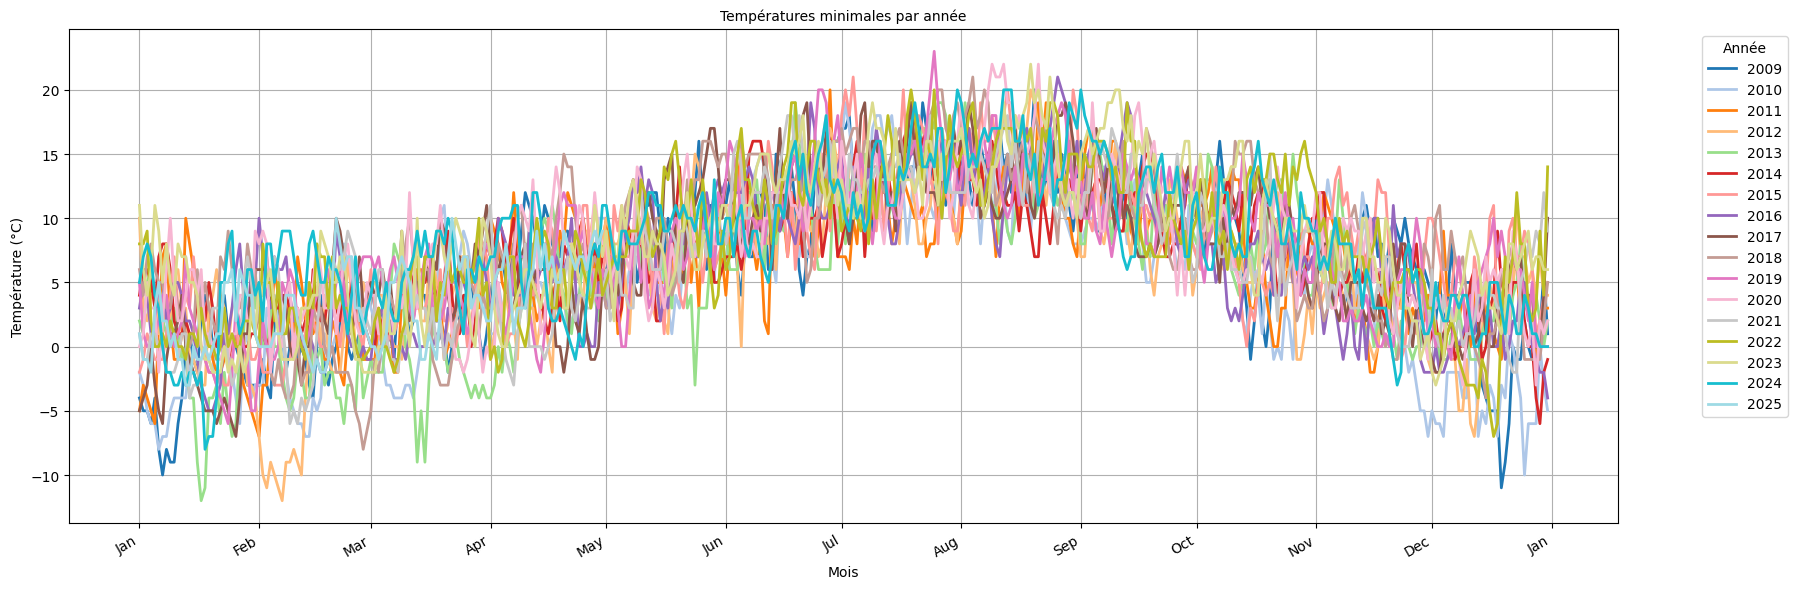

In [ ]:
# Liste des années à importer
annees = range(2009, 2026)

# Initialiser la figure
plt.figure(figsize=(18, 6))

# Colormap pour couleurs différentes par année
colors = plt.cm.get_cmap('tab20', len(annees))

for idx, annee in enumerate(annees):
    # Filtrer les données de l'année
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee].copy()

    # Remplacer l'année dans les dates par 2000 pour superposition
    df_annee.index = df_annee.index.map(lambda d: d.replace(year=2000))

    # Tracer la température minimale avec une couleur unique par année
    df_annee["MIN_TEMPERATURE_C"].plot(
        label=str(annee),
        color=colors(idx),
        lw=2
    )

# Configuration de l'axe des X pour n’afficher que les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

# Titre et labels
plt.title("Températures minimales par année", fontsize=10)
plt.xlabel("Mois")
plt.ylabel("Température (°C)")
plt.legend(title="Année", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

C:\Users\dvesa\AppData\Local\Temp\ipykernel_37104\3786489402.py:8: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  colors = plt.cm.get_cmap('tab20', len(annees))


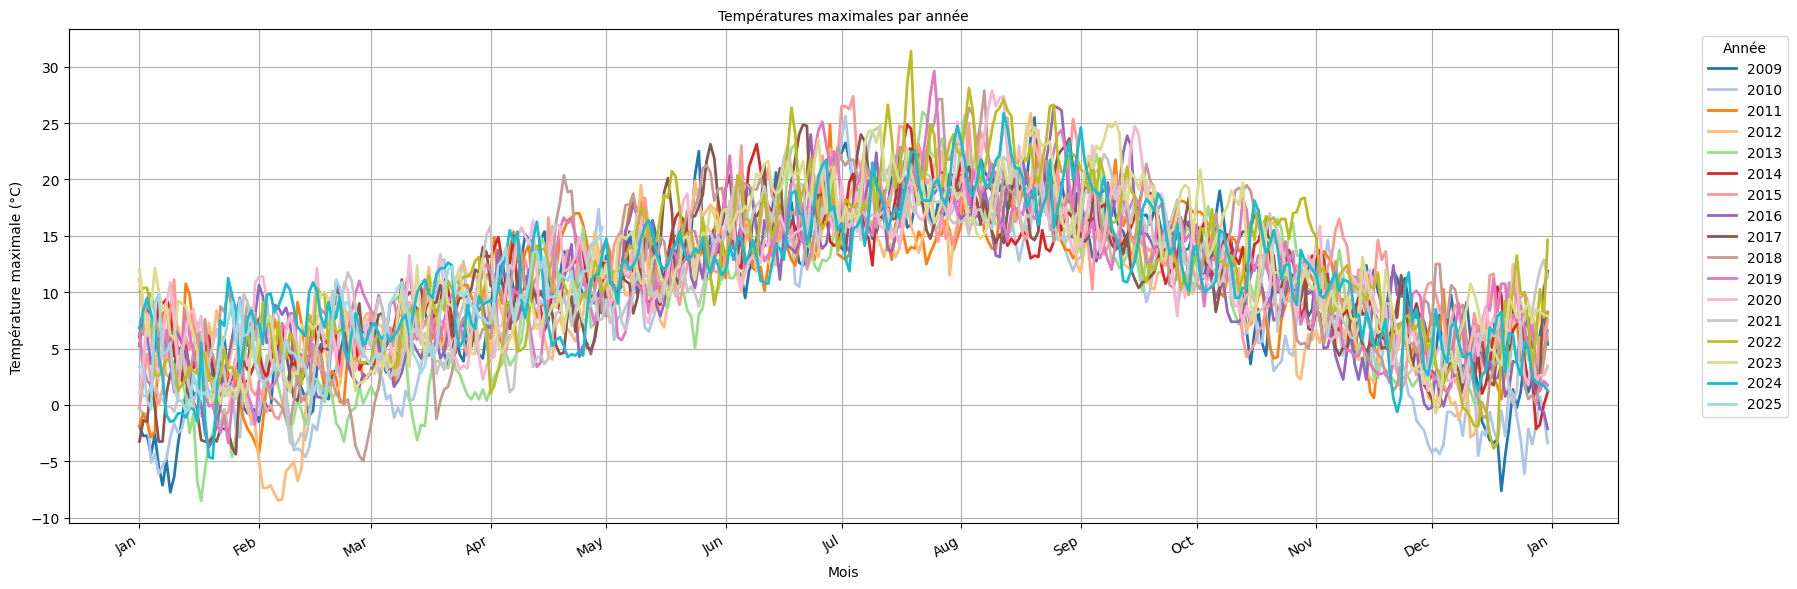

In [ ]:
# Liste des années à importer
annees = range(2009, 2026)

# Initialiser la figure
plt.figure(figsize=(18, 6))

# Colormap pour couleurs différentes par année
colors = plt.cm.get_cmap('tab20', len(annees))

for idx, annee in enumerate(annees):
    # Filtrer les données de l'année
    df_annee = data_climate_reims_2009_2026[data_climate_reims_2009_2026.index.year == annee].copy()

    # Remplacer l'année dans les dates par 2000 pour superposition
    df_annee.index = df_annee.index.map(lambda d: d.replace(year=2000))

    # Tracer la température moyenne avec une couleur unique par année
    df_annee["MEAN_TEMPERATURE_C"].plot(
        label=str(annee),
        color=colors(idx),
        lw=2
    )

# Configuration de l'axe des X pour n’afficher que les mois
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.

# Titre et labels
plt.title("Températures moyennes par année", fontsize=10)
plt.xlabel("Mois")
plt.ylabel("Température (°C)")
plt.legend(title="Année", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()

In [137]:
def temp_mean_max_min(data1, data2, data_designatin_1, data_designatin_2):
    """
    Affiche la distribution des données sous forme de box plot.

    Parameters:
    - data : list ou array-like
        Les données numériques à analyser.
    - bins : int (par défaut 30)
        Le nombre de barres pour l'histogramme.
    - titre : str
        Le titre du graphique.
    """
    
    # Liste des années à importer
    annees = range(2009, 2026)

    # Nombre de subplots nécessaires
    cols = 2  # Nombre de colonnes
    rows = len(annees) # Nombre de lignes

    i = 1
    
    #Initialiser le graphique
    plt.figure(figsize=(cols*14,rows*7))
    
    for idx, annee in enumerate(annees):
        

        plt.subplot(rows, cols, i)
        # Filtrer les données de l'année
        data2_df_annee = data2[data2.index.year == annee].copy()

        # Remplacer l'année dans les dates par 2000 pour superposition
        data2_df_annee.index = data2_df_annee.index.map(lambda d: d.replace(year=2000))

        # Tracer la température moyenne avec une couleur unique par année
        data2_df_annee["MEAN_TEMPERATURE_C"].plot(
            label=f"Temp Moyenne {annee}",
            color="blue",
            lw=2
        )

        # Tracer la température maximale avec une couleur unique par année
        data2_df_annee["MAX_TEMPERATURE_C"].plot(
            label=f"Temp Maximale {annee}",
            color="red",
            lw=2
        )

        # Tracer la température minimale avec une couleur unique par année
        data2_df_annee["MIN_TEMPERATURE_C"].plot(
            label=f"Temp minimale {annee}",
            color="green",
            lw=2
        )

        # Configuration de l'axe des X pour n’afficher que les mois
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
        plt.xlabel("Date")
        plt.ylabel("Température (°C)")
        plt.title(f"{data_designatin_1} : {annee}")
        plt.ylim(-10, 50)  # Limites pour l'axe Y
        plt.legend()
        plt.grid()

        plt.subplot(rows, cols, i+1)
        # Filtrer les données de l'année
        data1_df_annee = data1[data1.index.year == annee].copy()

        # Remplacer l'année dans les dates par 2000 pour superposition
        data1_df_annee.index = data1_df_annee.index.map(lambda d: d.replace(year=2000))

        # Tracer la température moyenne avec une couleur unique par année
        data1_df_annee["tasAdjust"].plot(
            label=f"Temp Moyenne {annee}",
            color="blue",
            lw=2
        )

        # Tracer la température maximale avec une couleur unique par année
        data1_df_annee["tasmaxAdjust"].plot(
            label=f"Temp Maximale {annee}",
            color="red",
            lw=2
        )

        # Tracer la température minimale avec une couleur unique par année
        data1_df_annee["tasminAdjust"].plot(
            label=f"Temp minimale {annee}",
            color="green",
            lw=2
        )
        # Configuration de l'axe des X pour n’afficher que les mois
        plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b'))  # 'Jan', 'Feb', etc.
        plt.xlabel("Date")
        plt.ylabel("Température (°C)")
        plt.title(f"{data_designatin_2} : {annee}")
        plt.ylim(-10, 50)
        plt.legend()
        plt.grid()

        i = i + 2
        
    # Afficher le graphique
    plt.show()

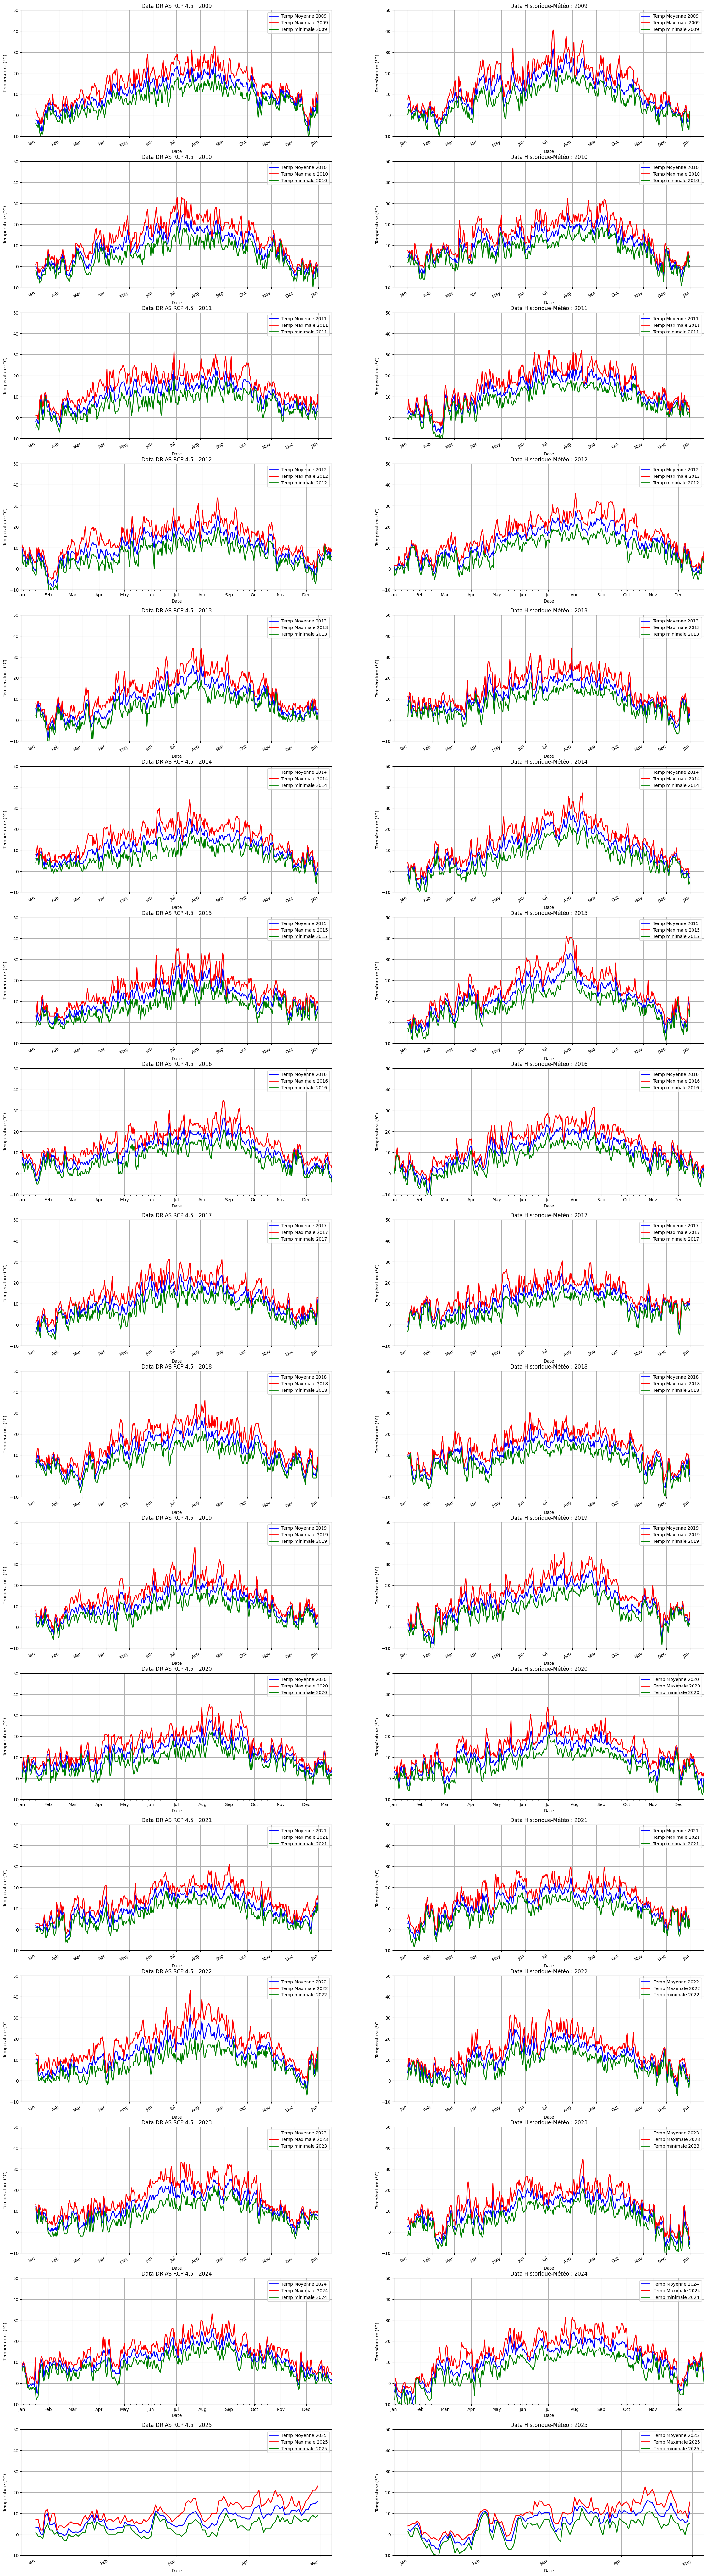

In [155]:
temp_mean_max_min(data_rcp_4_5.loc[:"04-2025", :], data_climate_reims_2009_2026.loc[:"04-2025", :], "Data DRIAS RCP 4.5", "Data Historique-Météo")

In [156]:
# Corrélation pour la température
correlation_temp = data_rcp_4_5.loc[:"04-2025", "tasAdjust"].corr(data_climate_reims_2009_2026.loc[:"04-2025", "MEAN_TEMPERATURE_C"] )
print("Corrélation température : ", correlation_temp)


Corrélation température :  0.7210302103320038


In [ ]:
# les colonnes concernées
rcp = data_rcp_4_5[["tasAdjust", "tasmaxAdjust", "tasminAdjust"]]
obs = data_climate_reims_2009_2026[["MEAN_TEMPERATURE_C", "MAX_TEMPERATURE_C", "MIN_TEMPERATURE_C"]]

# S'assurer que les index sont les mêmes (dates)
rcp, obs = rcp.align(obs, join='inner', axis=0)

# Matrice de corrélation croisée
correlation_matrix = pd.DataFrame(
    {rcp_col: obs.corrwith(rcp[rcp_col]) for rcp_col in rcp.columns}
)

# Optionnel : arrondir à 2 chiffres
correlation_matrix = correlation_matrix.round(2)

print(correlation_matrix)


                    tasAdjust  tasmaxAdjust  tasminAdjust
MEAN_TEMPERATURE_C       0.72          0.72          0.68
MAX_TEMPERATURE_C        0.72          0.73          0.68
MIN_TEMPERATURE_C        0.66          0.67          0.63


In [142]:
data_rcp_4_5.tail()

Latitude  Longitude  tasminAdjust  tasmaxAdjust  tasAdjust  \
Date                                                                     
2100-12-27   49.2427    4.03882          1.00          9.48       4.55   
2100-12-28   49.2427    4.03882          4.14         11.98       8.26   
2100-12-29   49.2427    4.03882          4.61          9.58       8.06   
2100-12-30   49.2427    4.03882          6.15         10.11       7.57   
2100-12-31   49.2427    4.03882          5.40          6.59       6.08   

            prtotAdjust  prsnAdjust  hussAdjust  rsdsAdjust  rldsAdjust  \
Date                                                                      
2100-12-27     0.000000         0.0    0.004967      51.618     286.619   
2100-12-28     0.000042         0.0    0.005910      38.051     318.954   
2100-12-29     0.000032         0.0    0.005180      30.541     324.057   
2100-12-30     0.000108         0.0    0.005884      17.554     334.634   
2100-12-31     0.000027         0.0    0.005043      15.093     337.720   

            sfcWindAdjust  evspsblpotAdjust  
Date                                         
2100-12-27          3.158          0.000002  
2100-12-28          4.029          0.000004  
2100-12-29          4.353          0.000007  
2100-12-30         10.269          0.000009  
2100-12-31          5.053          0.000007

In [152]:
data_rcp_4_5.loc[:"04-2025", :]

Latitude  Longitude  tasminAdjust  tasmaxAdjust  tasAdjust  \
Date                                                                     
2006-01-01   49.2427    4.03882         -3.15          4.65      -0.02   
2006-01-02   49.2427    4.03882          0.04          4.06       2.03   
2006-01-03   49.2427    4.03882          8.59          8.97       8.82   
2006-01-04   49.2427    4.03882          9.76         13.06      11.92   
2006-01-05   49.2427    4.03882          5.15         11.00       7.20   
...              ...        ...           ...           ...        ...   
2025-04-26   49.2427    4.03882          1.95         11.48       6.56   
2025-04-27   49.2427    4.03882          2.57          9.68       7.12   
2025-04-28   49.2427    4.03882         -0.27         11.23       5.62   
2025-04-29   49.2427    4.03882          4.43          7.86       6.10   
2025-04-30   49.2427    4.03882          5.25         15.30      10.68   

            prtotAdjust  prsnAdjust  hussAdjust  rsdsAdjust  rldsAdjust  \
Date                                                                      
2006-01-01     0.000003    0.000003    0.003503      53.157     264.926   
2006-01-02     0.000097    0.000012    0.005015       9.143     347.306   
2006-01-03     0.000008    0.000000    0.008196       8.756     381.686   
2006-01-04     0.000001    0.000000    0.007773      16.775     355.457   
2006-01-05     0.000000    0.000000    0.006088      29.116     337.960   
...                 ...         ...         ...         ...         ...   
2025-04-26     0.000002    0.000000    0.004456     140.926     315.814   
2025-04-27     0.000006    0.000000    0.004440     188.521     306.198   
2025-04-28     0.000000    0.000000    0.003750     315.424     273.941   
2025-04-29     0.000051    0.000000    0.005141      38.546     354.740   
2025-04-30     0.000008    0.000000    0.007063     120.389     344.989   

            sfcWindAdjust  evspsblpotAdjust  
Date                                         
2006-01-01          2.138      1.800000e-06  
2006-01-02          7.012      5.000000e-07  
2006-01-03          8.374      2.000000e-06  
2006-01-04          5.803      5.500000e-06  
2006-01-05          1.557      2.200000e-06  
...                   ...               ...  
2025-04-26          3.631      2.640000e-05  
2025-04-27          3.146      2.290000e-05  
2025-04-28          1.963      2.760000e-05  
2025-04-29          4.372      1.570000e-05  
2025-04-30          2.712      2.590000e-05  

[7060 rows x 12 columns]

In [ ]:
# Reshape requis pour sklearn
X = drias_common["tasAdjust"].values.reshape(-1, 1)
y = obs_common["MEAN_TEMPERATURE_C"].values

model = LinearRegression()
model.fit(X, y)

# Coefficients
print(f"y = {model.coef_[0]:.3f} * x + {model.intercept_:.3f}")

# Sélectionner les données futures
drias_future = data_drias.loc["2025":, "tasAdjust"]
X_future = drias_future.values.reshape(-1, 1)

# Prédictions des températures "observées"
predicted_obs = model.predict(X_future)

# Créer DataFrame
projection_obs = pd.DataFrame({
    "Projected_obs_like": predicted_obs,
    "Drias_raw": drias_future.values
}, index=drias_future.index)

In [ ]:
plt.figure(figsize=(15, 6))
obs_common["MEAN_TEMPERATURE_C"].plot(label="Observations réelles (2009–2025)", color="blue")
projection_obs["Projected_obs_like"].plot(label="Projection des observations (2025–2100)", color="red", linestyle="--")
projection_obs["Drias_raw"].plot(label="Drias brut", color="gray", alpha=0.4)

plt.title("Projection des températures observées à partir des données DRIAS")
plt.ylabel("Température moyenne (°C)")
plt.xlabel("Année")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()